In [30]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import gymnasium as gym
import gym_pusht
from utils import Episode, TrajectoryStep

# 设置matplotlib显示中文
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False


In [21]:
# 运行测试脚本生成数据
!python test_trajectory_recording.py


=== 测试单个轨迹记录 ===
初始观测类型: <class 'dict'>
初始观测键: ['pixels', 'agent_pos']
步骤 0: pixels shape=(96, 96, 3), agent_pos=[253.01428777 380.75551696], reward=0.0000
  记录的pixels shape=(96, 96, 3)
步骤 1: pixels shape=(96, 96, 3), agent_pos=[232.32222375 396.11209849], reward=0.0000
  记录的pixels shape=(96, 96, 3)
步骤 2: pixels shape=(96, 96, 3), agent_pos=[238.66397189 306.01569351], reward=0.0000
  记录的pixels shape=(96, 96, 3)
步骤 3: pixels shape=(96, 96, 3), agent_pos=[223.91165403 302.24416312], reward=0.0000
  记录的pixels shape=(96, 96, 3)
步骤 4: pixels shape=(96, 96, 3), agent_pos=[218.17635228 255.24059869], reward=0.0000
  记录的pixels shape=(96, 96, 3)

轨迹已保存到: test_data\test_pixels_trajectory.pickle

=== 验证保存的数据 ===
加载了 5 个步骤
步骤 0: pixels是否为None=False, pixels shape=(96, 96, 3), agent_pos=[253.01428777 380.75551696]
步骤 1: pixels是否为None=False, pixels shape=(96, 96, 3), agent_pos=[232.32222375 396.11209849]
步骤 2: pixels是否为None=False, pixels shape=(96, 96, 3), agent_pos=[238.66397189 306.01569351]
步骤 3:

In [31]:
# 加载轨迹数据
data_path = r"data\pusht_human_mouse_trajectories\2_trajectories.pickle"

with open(data_path, 'rb') as f:
    episodes = pickle.load(f)

print(f"加载了 {len(episodes)} 个episode")

if episodes:
    episode = episodes[0]
    print(f"Episode信息:")
    print(f"  - ID: {episode.episode_id}")
    print(f"  - 步数: {episode.length}")
    print(f"  - 总奖励: {episode.total_reward:.4f}")
    print(f"  - 成功: {episode.success}")
    
    # 检查第一步的观测
    if episode.steps:
        first_step = episode.steps[0]
        obs = first_step.observation
        
        print(f"\n第一步观测分析:")
        print(f"  - 观测类型: {type(obs)}")
        
        if isinstance(obs, dict):
            print(f"  - 观测键: {list(obs.keys())}")
            
            if 'pixels' in obs:
                pixels = obs['pixels']
                print(f"  - Pixels:")
                print(f"    * 类型: {type(pixels)}")
                print(f"    * Shape: {pixels.shape}")
                print(f"    * 数据类型: {pixels.dtype}")
                print(f"    * 值范围: [{pixels.min()}, {pixels.max()}]")
                print(f"    * 是否为None: {pixels is None}")
            
            if 'agent_pos' in obs:
                agent_pos = obs['agent_pos']
                print(f"  - Agent Position:")
                print(f"    * 类型: {type(agent_pos)}")
                print(f"    * Shape: {agent_pos.shape}")
                print(f"    * 值: {agent_pos}")
        else:
            print(f"  - 观测不是字典类型，Shape: {obs.shape if hasattr(obs, 'shape') else 'No shape'}")


加载了 1 个episode
Episode信息:
  - ID: 0
  - 步数: 108
  - 总奖励: 60.1368
  - 成功: True

第一步观测分析:
  - 观测类型: <class 'dict'>
  - 观测键: ['pixels', 'agent_pos']
  - Pixels:
    * 类型: <class 'numpy.ndarray'>
    * Shape: (512, 512, 3)
    * 数据类型: uint8
    * 值范围: [65, 255]
    * 是否为None: False
  - Agent Position:
    * 类型: <class 'numpy.ndarray'>
    * Shape: (2,)
    * 值: [231.01911716 410.72344537]


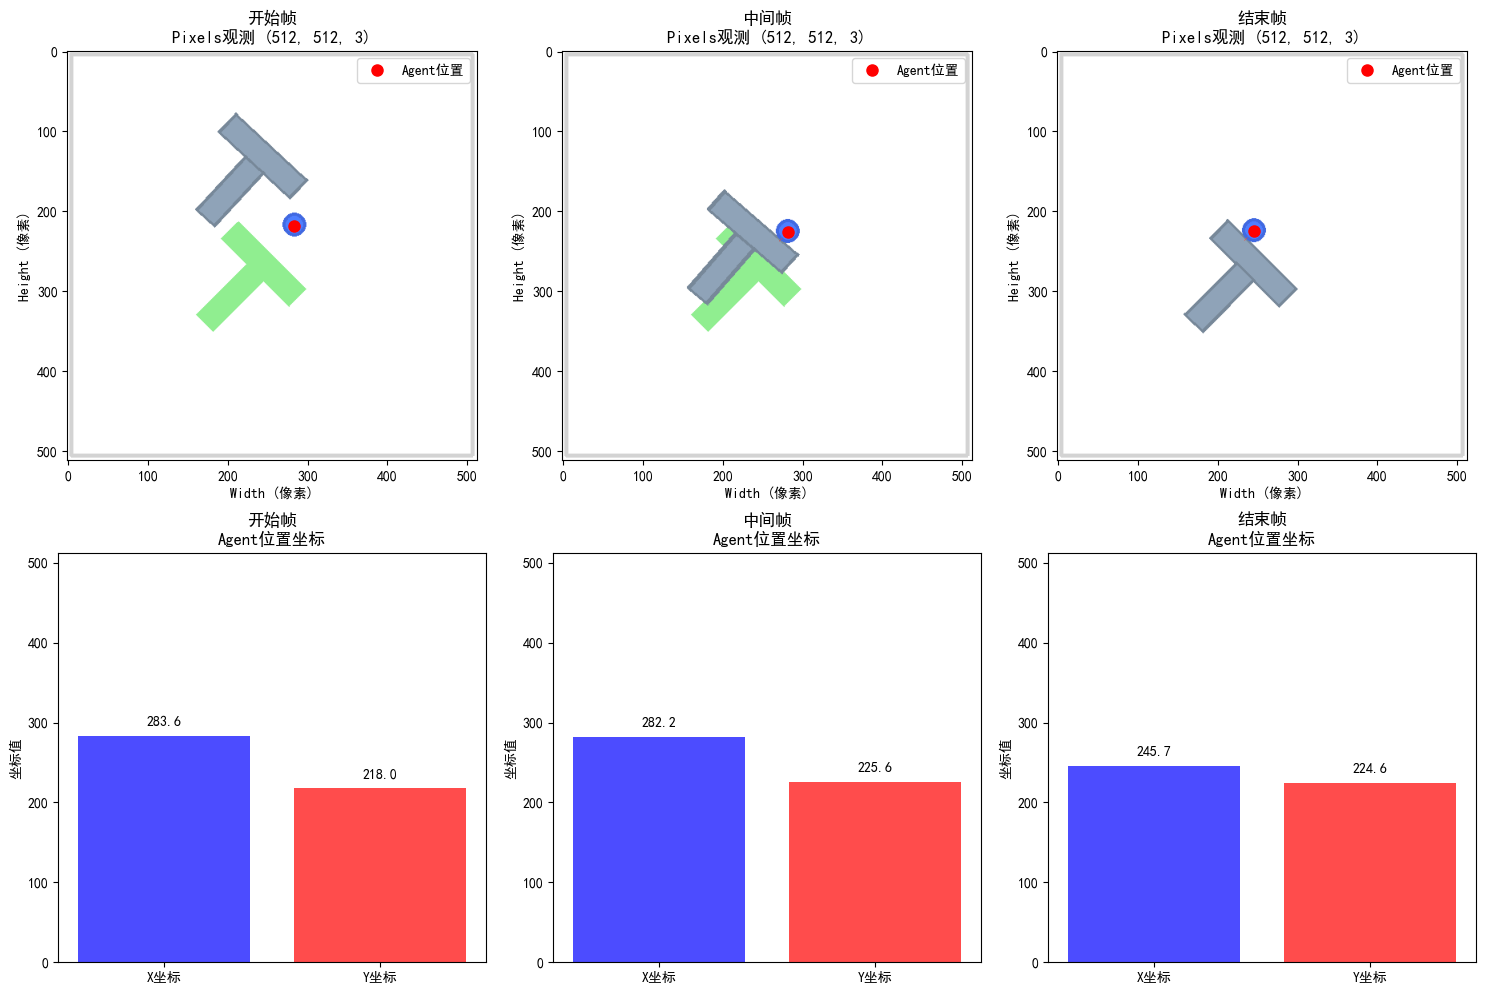

In [29]:
# 可视化轨迹中的关键帧
n_steps = len(episode.steps)
key_frames = [0, n_steps//2, -1] if n_steps > 2 else list(range(n_steps))
frame_names = ['开始帧', '中间帧', '结束帧'] if n_steps > 2 else [f'第{i}帧' for i in range(n_steps)]

fig, axes = plt.subplots(2, len(key_frames), figsize=(5*len(key_frames), 10))
if len(key_frames) == 1:
    axes = axes.reshape(2, 1)

for i, (frame_idx, frame_name) in enumerate(zip(key_frames, frame_names)):
    if frame_idx < 0:
        frame_idx = n_steps + frame_idx
    
    step = episode.steps[frame_idx]
    obs = step.observation
    
    if isinstance(obs, dict) and 'pixels' in obs and 'agent_pos' in obs:
        pixels = obs['pixels']
        agent_pos = obs['agent_pos']
        
        # 显示pixels图像
        axes[0, i].imshow(pixels)
        axes[0, i].set_title(f'{frame_name}\nPixels观测 {pixels.shape}')
        axes[0, i].set_xlabel('Width (像素)')
        axes[0, i].set_ylabel('Height (像素)')
        
        # 在图像上标记agent位置
        # agent_pos是在[0, 512]范围内，需要缩放到[0, 96]图像坐标
        agent_x_img = agent_pos[0] * pixels.shape[1] / 512
        agent_y_img = agent_pos[1] * pixels.shape[0] / 512
        
        axes[0, i].plot(agent_x_img, agent_y_img, 'ro', markersize=8, 
                       label=f'Agent位置')
        axes[0, i].legend()
        
        # 显示agent位置数据
        axes[1, i].bar(['X坐标', 'Y坐标'], agent_pos, color=['blue', 'red'], alpha=0.7)
        axes[1, i].set_title(f'{frame_name}\nAgent位置坐标')
        axes[1, i].set_ylabel('坐标值')
        axes[1, i].set_ylim(0, 512)
        
        # 添加数值标签
        for j, val in enumerate(agent_pos):
            axes[1, i].text(j, val + 10, f'{val:.1f}', ha='center', va='bottom')
    else:
        axes[0, i].text(0.5, 0.5, 'No pixels data', ha='center', va='center')
        axes[1, i].text(0.5, 0.5, 'No agent_pos data', ha='center', va='center')

plt.tight_layout()
plt.show()


In [24]:
# 提取所有步骤的数据进行统计分析
agent_positions = []
pixels_shapes = []
rewards = []
actions = []

for i, step in enumerate(episode.steps):
    obs = step.observation
    
    if isinstance(obs, dict):
        if 'agent_pos' in obs:
            agent_positions.append(obs['agent_pos'].copy())
        if 'pixels' in obs:
            pixels_shapes.append(obs['pixels'].shape)
    
    rewards.append(step.reward)
    actions.append(step.action.copy())

agent_positions = np.array(agent_positions) if agent_positions else np.array([])
rewards = np.array(rewards)
actions = np.array(actions) if actions else np.array([])

print("=== 轨迹数据统计 ===")
print(f"总步数: {len(episode.steps)}")

if len(agent_positions) > 0:
    print(f"\nAgent位置统计:")
    print(f"  - Agent位置数组shape: {agent_positions.shape}")
    print(f"  - X坐标范围: [{agent_positions[:, 0].min():.2f}, {agent_positions[:, 0].max():.2f}]")
    print(f"  - Y坐标范围: [{agent_positions[:, 1].min():.2f}, {agent_positions[:, 1].max():.2f}]")
    print(f"  - X坐标标准差: {agent_positions[:, 0].std():.2f}")
    print(f"  - Y坐标标准差: {agent_positions[:, 1].std():.2f}")

if len(pixels_shapes) > 0:
    print(f"\nPixels数据统计:")
    print(f"  - 所有pixels观测的shape: {set(pixels_shapes)}")
    print(f"  - Pixels观测一致性: {'一致' if len(set(pixels_shapes)) == 1 else '不一致'}")

print(f"\n奖励统计:")
print(f"  - 奖励范围: [{rewards.min():.4f}, {rewards.max():.4f}]")
print(f"  - 平均奖励: {rewards.mean():.4f}")
print(f"  - 奖励标准差: {rewards.std():.4f}")

if len(actions) > 0:
    print(f"\n动作统计:")
    print(f"  - 动作数组shape: {actions.shape}")
    print(f"  - X动作范围: [{actions[:, 0].min():.2f}, {actions[:, 0].max():.2f}]")
    print(f"  - Y动作范围: [{actions[:, 1].min():.2f}, {actions[:, 1].max():.2f}]")


=== 轨迹数据统计 ===
总步数: 5

Agent位置统计:
  - Agent位置数组shape: (5, 2)
  - X坐标范围: [218.18, 253.01]
  - Y坐标范围: [255.24, 396.11]
  - X坐标标准差: 12.13
  - Y坐标标准差: 52.66

Pixels数据统计:
  - 所有pixels观测的shape: {(96, 96, 3)}
  - Pixels观测一致性: 一致

奖励统计:
  - 奖励范围: [0.0000, 0.0000]
  - 平均奖励: 0.0000
  - 奖励标准差: 0.0000

动作统计:
  - 动作数组shape: (5, 2)
  - X动作范围: [53.63, 493.64]
  - Y动作范围: [63.21, 454.78]


In [25]:
# read pickle file
import pickle
data = pickle.load(open('data/pusht_human_mouse_trajectories/2_trajectories.pickle', 'rb'))

In [26]:
data[0].steps[0].observation

IndexError: list index out of range